In [1]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

paths_to_image = ["script/positive/image/TCGA_CS_4944_20010208_11.tif",
                  "script/positive/image/TCGA_CS_4944_20010208_9.tif",
                  "script/positive/image/TCGA_CS_4944_20010208_10.tif"];

path_to_model = "clf-resnet-weights.hdf5";
model = tf.keras.models.load_model(path_to_model)
img_array = np.empty([len(paths_to_image),256,256,3]);
counter = 0
for path_to_image in paths_to_image:
    img = cv2.imread(path_to_image)
    img = img / 255.0 # we need to normalise (but see what happens if you don't)
    img = np.expand_dims(img, axis=0)
    img_array[counter] = img
    counter += 1
img_array = img_array.astype('float32')

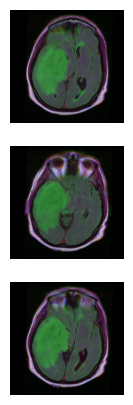

In [2]:
counter = 1
fig = plt.figure(figsize=(5, 5))
for img in img_array:
    fig.add_subplot(len(paths_to_image), 1, counter)
    plt.imshow(img)
    plt.axis('off')
    counter+=1

# Model tested in the images

In [3]:
def map_labels(index):
    return classes[index]

prediction = model.predict(img_array)
max_index_prediction = np.argmax(prediction, axis = 1)
classes = ["No tumour", "Tumour"]

pred_class = [map_labels(i) for i in max_index_prediction]
print(prediction)
print(pred_class)

1/1 [==============================] - 3s 3s/step
[[2.7504185e-15 1.0000000e+00]
 [5.0022937e-17 1.0000000e+00]
 [1.4429081e-16 1.0000000e+00]]
['Tumour', 'Tumour', 'Tumour']


# Shap explanation

In [4]:
import shap
shap.initjs()
explainers = []
masks = ['blur(64,64)']

In [5]:
shap_values = {}
for mask in masks:
    shap_values_array= []
    masker = shap.maskers.Image(mask, shape=img_array[0].shape) 
    explainer=shap.Explainer(model, masker, output_names=classes, seed = 42)
    for img in img_array:
        shap_values_array.append(explainer(np.expand_dims(img, axis = 0), max_evals = 2000, batch_size = 50, outputs=shap.Explanation.argsort.flip[:1]))
    shap_values[mask] = shap_values_array

  0%|          | 0/1998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:08, 248.04s/it]                                                                  


  0%|          | 0/1998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:05, 245.63s/it]                                                                  


  0%|          | 0/1998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:05, 245.48s/it]                                                                  


blur(64,64)


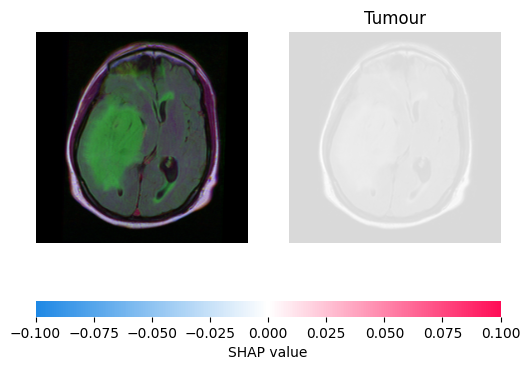

(1, 256, 256, 3, 1)


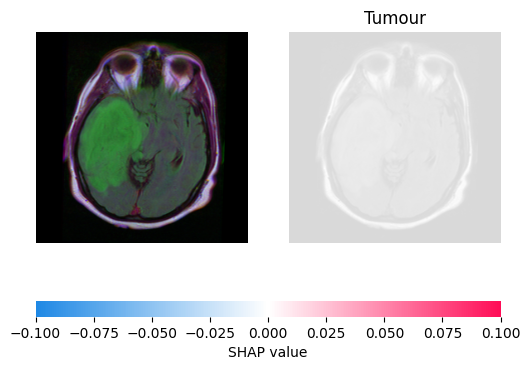

(1, 256, 256, 3, 1)


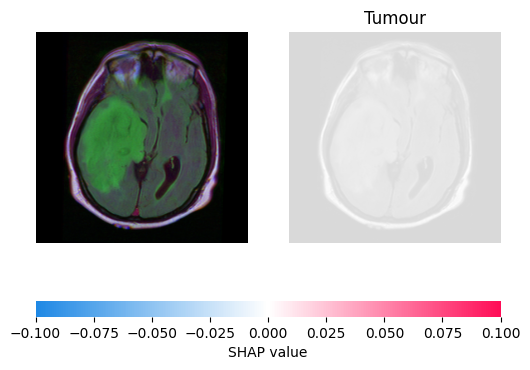

(1, 256, 256, 3, 1)


In [6]:
for mask in masks:
    print(mask)
    for shap_value in shap_values[mask]:
        shap.image_plot(shap_value)
        print(shap_value.values.shape)

In [7]:
np.sum(shap_value.values[0, :, :, 2, 0])

0.0

blur(64,64)
0.0


Attempting to set identical low and high zlims makes transformation singular; automatically expanding.


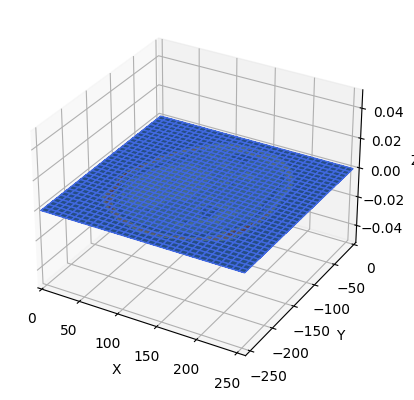

0.0


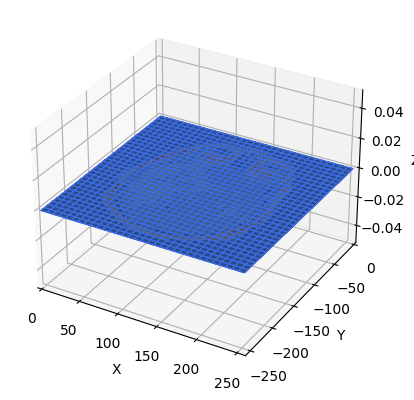

0.0


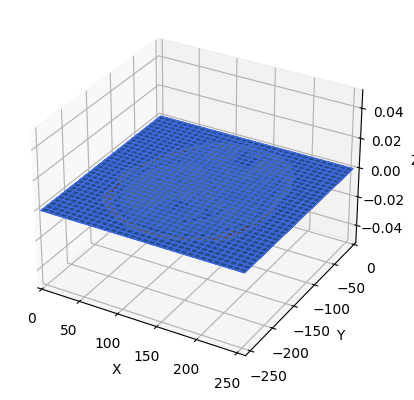

In [8]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

for mask in masks:
    print(mask)
    for shap_value in shap_values[mask]:
        z = (shap_value.values[0, :, :, 0, 0] + shap_value.values[0, :, :, 1, 0] + shap_value.values[0, :, :, 2, 0]) / 3
        print(np.max(z))
        z2 = (shap_value.data[0, :, :, 0] + shap_value.data[0, :, :, 1] + shap_value.data[0, :, :, 2]) / 3
        ax = plt.figure().add_subplot(projection='3d')
        
        axis = np.linspace(0, 255, num = 256)
        x, y = np.meshgrid(axis, axis, indexing='ij')

        ax.plot_surface(y, -x, z, edgecolor='royalblue', lw=1, rstride=8, cstride=8,
                        alpha=0.7)
        
        ax.contourf(y, -x, z2, zdir='z', offset=np.min(z), cmap='coolwarm')

        ax.set(xlim=(np.min(x), np.max(x)), ylim=(np.min(-y), np.max(-y)), zlim=((np.min(z), np.max(z))),
               xlabel='X', ylabel='Y', zlabel='Z')

        plt.show()

1/1 [==============================] - 0s 192ms/step


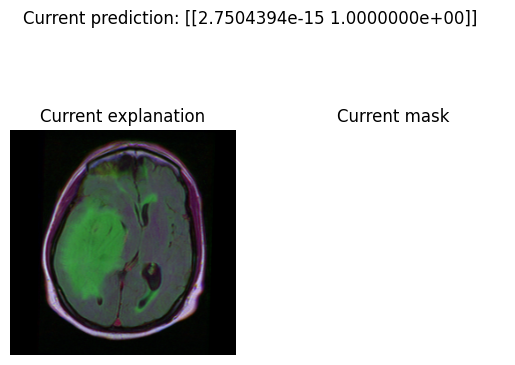

In [9]:
average = []
for shap_value in shap_values['blur(64,64)']:
    average = (shap_value.values[0, :, :, 0, 0] + shap_value.values[0, :, :, 1, 0] + shap_value.values[0, :, :, 2, 0]) / 3
levels = np.flip(np.unique(average))
counter = 0
shap_expl = []
min_masks = np.empty([256,256,3])
for level in levels:
    counter = counter + 1
    pixels = np.where(average == level)
    min_masks[pixels[0], pixels[1], :] = True
    shap_expl = np.where(min_masks, img_array[0], 0)
    pre = model.predict(np.expand_dims(shap_expl, axis=0))
    fig, axs = plt.subplots(1, 2)
    plt.suptitle("Current prediction: " + str(pre))
    axs[0].set_title("Current explanation")
    axs[0].imshow(shap_expl)
    axs[0].axis("off")
    axs[1].set_title("Current mask")
    axs[1].imshow(min_masks)
    axs[1].axis("off")
    argmax = np.argmax(pre, axis = 1)
    if (argmax == 1 and pre[0][argmax] > 0.5):
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

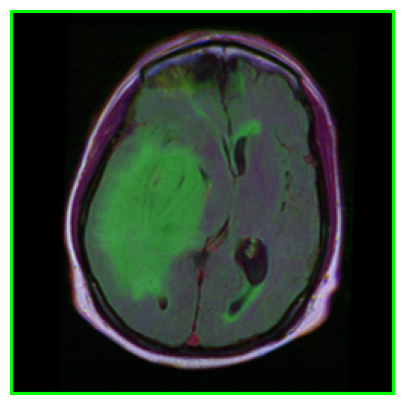

In [10]:
countours,hierarchy=cv2.findContours((np.float32(min_masks[:,:,0])*255).astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# draw contours
countoured_image = np.copy(img_array[0])
cv2.drawContours(countoured_image, countours, -1, (0,255,0), 2)

fig = plt.figure(figsize=(5, 5))
plt.imshow(countoured_image)
plt.axis("off")        

In [11]:
import os
import re

folder_path_01 = "mutants/m01_child/"
folder_path_10 = "mutants/m10_child/"

list_1 = [(os.path.join(folder_path_01) + image) for image in os.listdir(folder_path_01)]
list_2 = [(os.path.join(folder_path_10) + image) for image in os.listdir(folder_path_10)]

def extract_number(filename):
    match = re.search(r'_(\d+)\.', filename)
    if match:
        return int(match.group(1))
    else:
        return -1
    
sorted_list = sorted(list_1 + list_2, key=extract_number)
mutant_masks = [cv2.imread(f) for f in (sorted_list[:30])]

mutant_masks = [x for x in mutant_masks if x is not None]

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


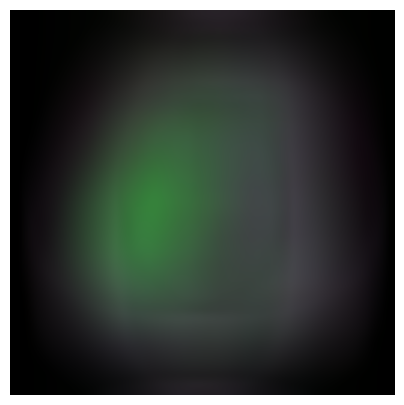

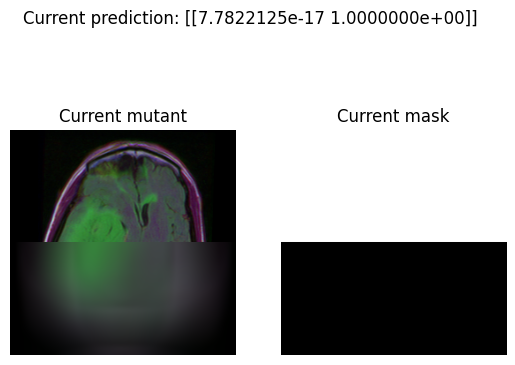

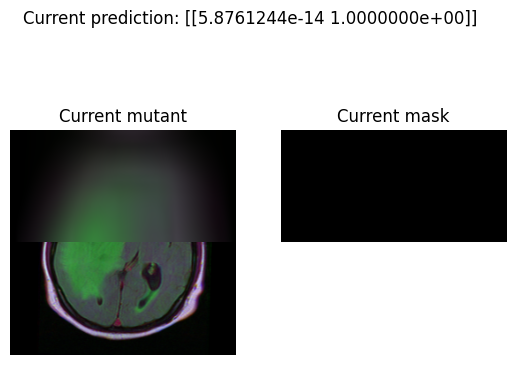

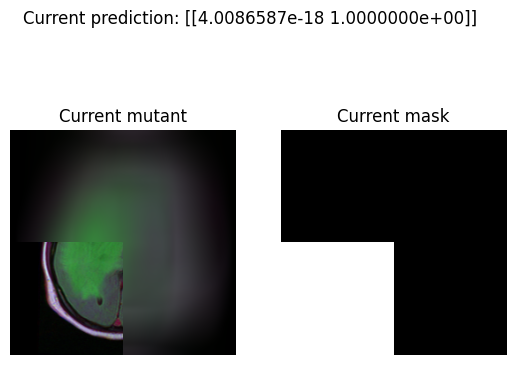

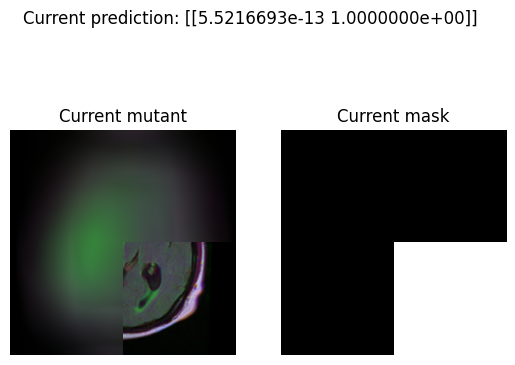

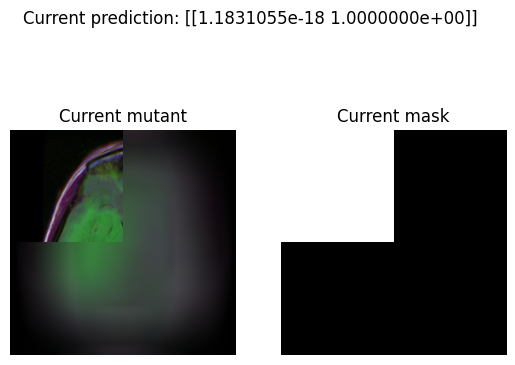

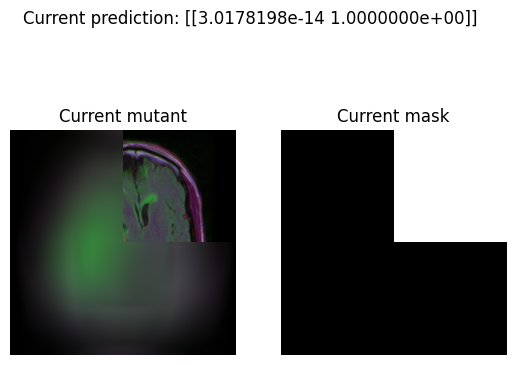

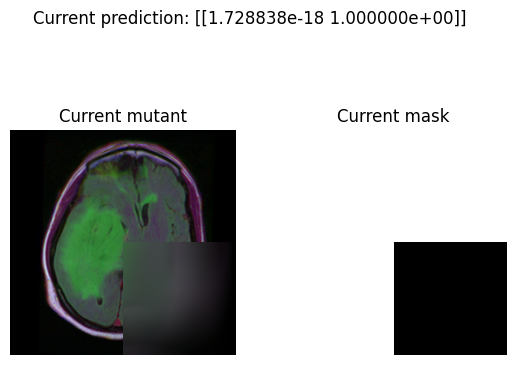

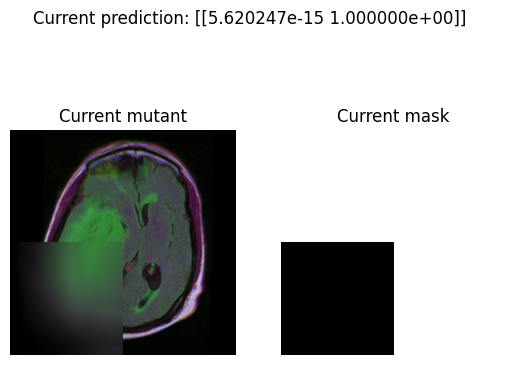

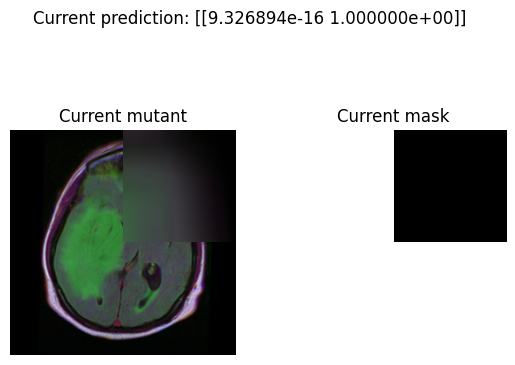

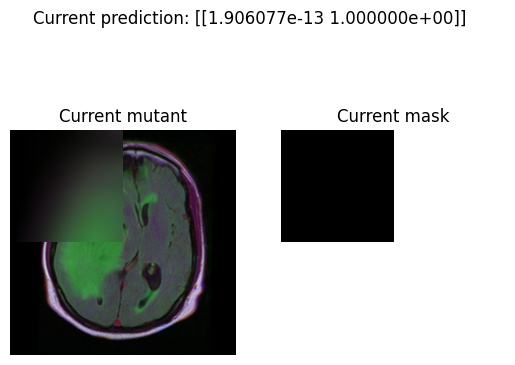

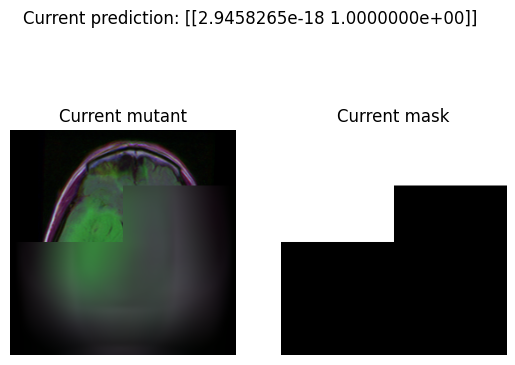

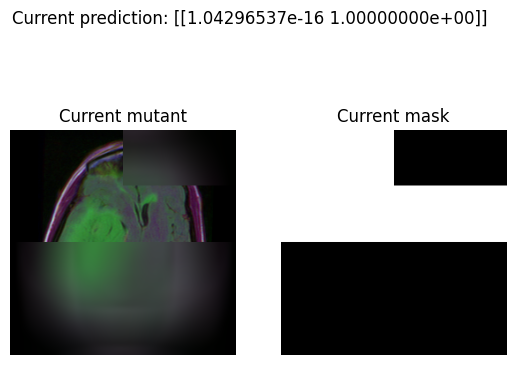

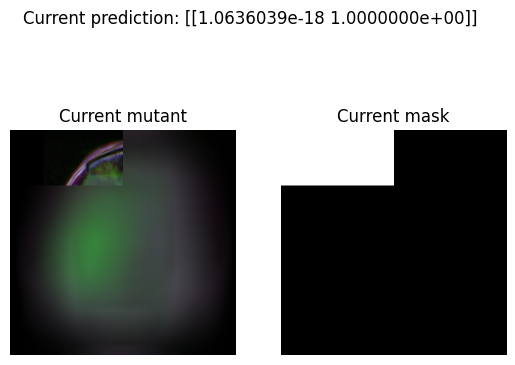

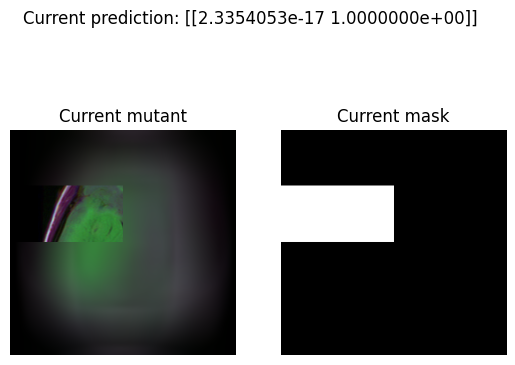

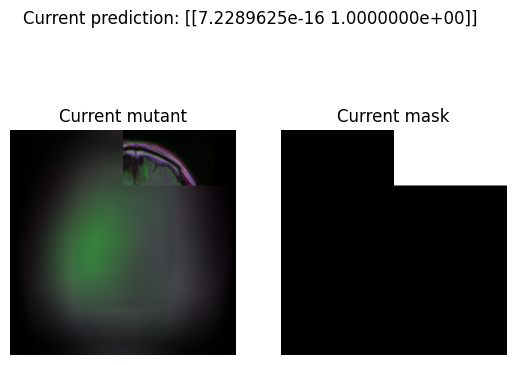

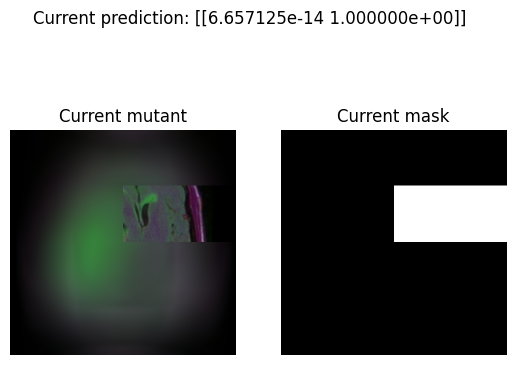

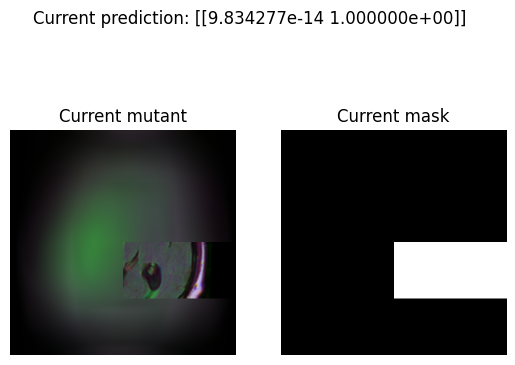

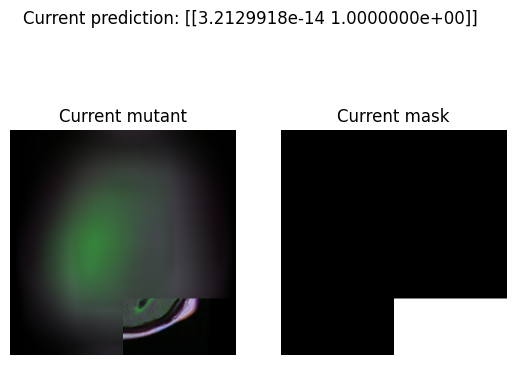

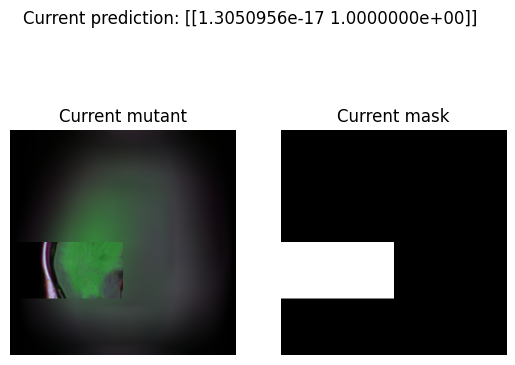

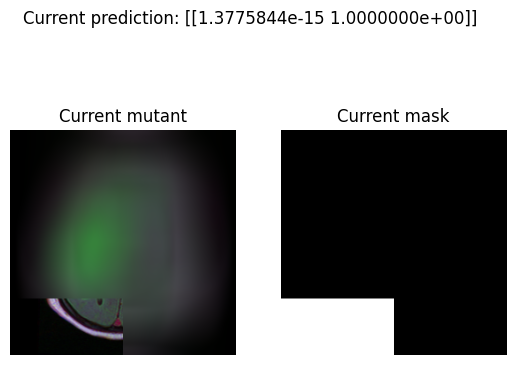

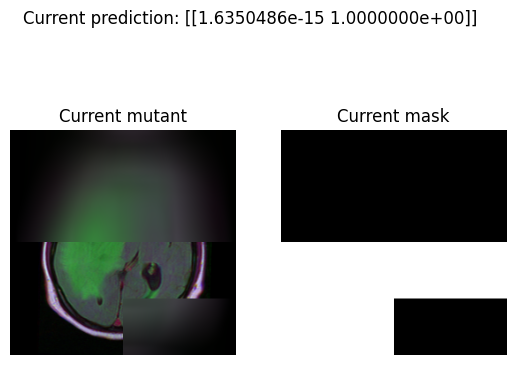

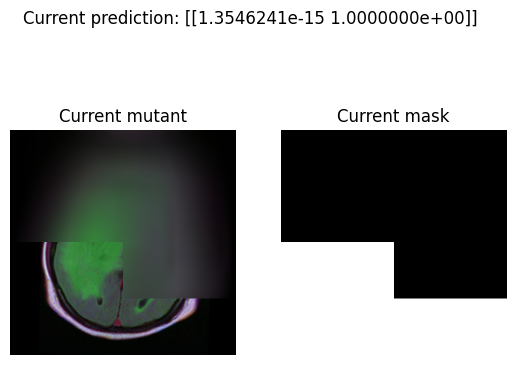

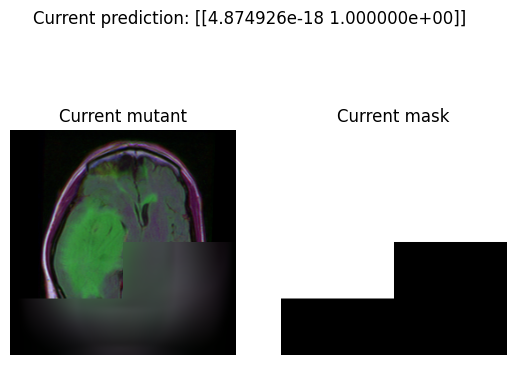

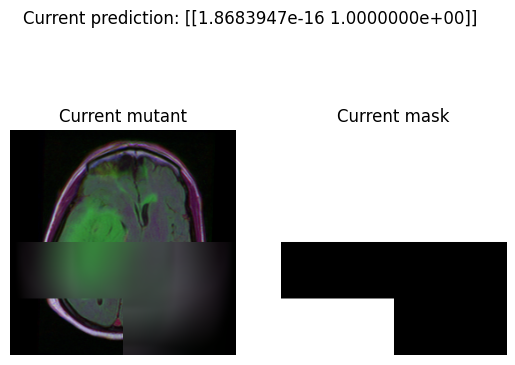

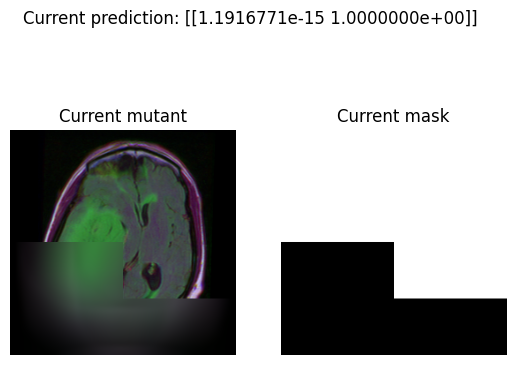

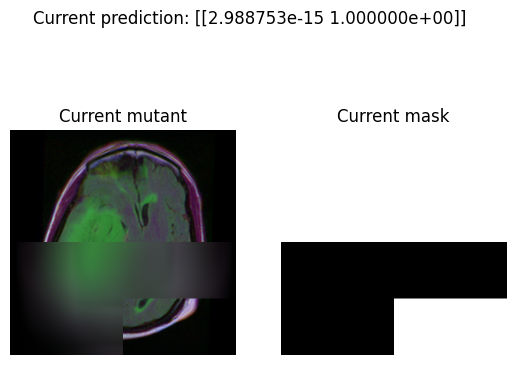

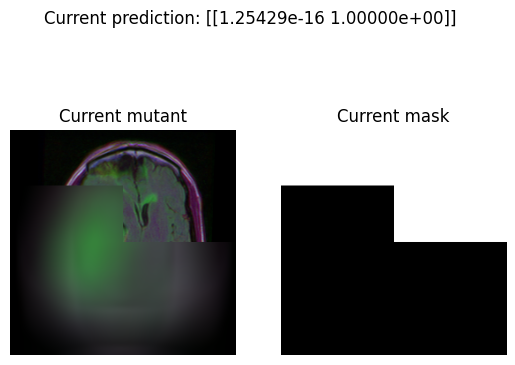

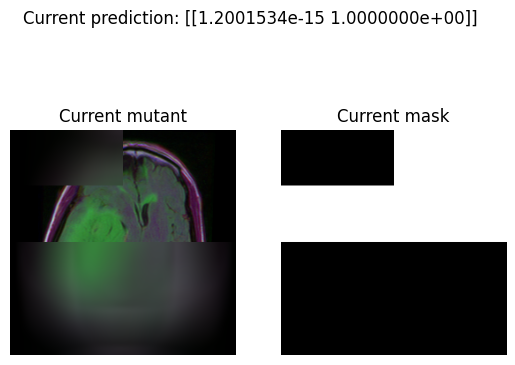

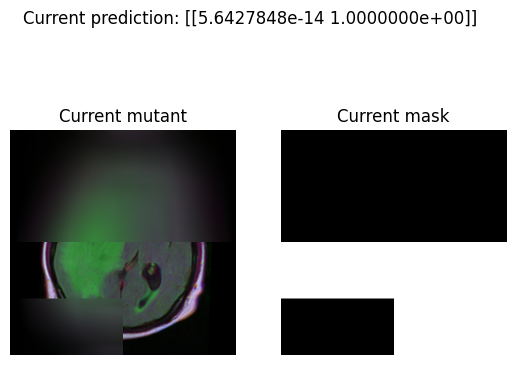

In [12]:
blurred_image = cv2.blur(img_array[0], (64,64))
fig = plt.figure(figsize=(5, 5))
plt.imshow(blurred_image)
plt.axis("off")

for mutant_mask in mutant_masks:
    mutant = np.where(mutant_mask, img_array[0], blurred_image)
    pre = model.predict(np.expand_dims(mutant, axis=0), verbose=0)
    fig, axs = plt.subplots(1, 2)
    plt.suptitle("Current prediction: " + str(pre))
    axs[0].set_title("Current mutant")
    axs[0].imshow(mutant)
    axs[0].axis("off")
    axs[1].set_title("Current mask")
    axs[1].imshow(mutant_mask)
    axs[1].axis("off")